###Project TelegramBot for StyleTransfer by Oparina Daria
------------------------------------------------------
#How it works
------------------------------------------------------
Write to bot @Style_transfer_bot

Begin with /start

Then he will send you an example of how you should send two photos

Send photo AND(!!!) write in the SAME message input | style

Then he will analyse the data and send you the result

Please, use VPN for it

In [1]:
!pip install pyTelegramBotAPI
!pip3 install torch torchvision
!pip3 install pillow==4.1.1
!pip install requests

In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

import telebot
from telebot import types
import requests

In [0]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# # отрисовка

# plt.figure()
# imshow(style_img, title='Style Image')

# plt.figure()
# imshow(content_img, title='Content Image')

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std
            
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [6]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

In [0]:
# style_img = image_loader("style_image.jpg")
# content_img = image_loader("input_image.jpg")

# input_img = content_img.clone()
# # if you want to use white noise instead uncomment the below line:
# # input_img = torch.randn(content_img.data.size(), device=device)

# # add the original input image to the figure:
# plt.figure()
# imshow(input_img, title='Input Image')
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img)

In [0]:
def run_style_transfer_bot():
    style_img = image_loader("style_image.jpg")
    content_img = image_loader("input_image.jpg")

    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    plt.figure()
    imshow(output, title='Output Image')

    output_cpu = output.cpu().clone()   
    output_cpu = output_cpu.squeeze(0)     
    output_cpu = unloader(output_cpu)
    plt.imshow(output_cpu)
    output_cpu = output_cpu.save("output.jpg")
    plt.ioff()
    plt.show()


In [0]:
# plt.figure()
# imshow(output, title='Output Image')

# output_cpu = output.cpu().clone()   
# output_cpu = output_cpu.squeeze(0)     
# output_cpu = unloader(output_cpu)
# plt.imshow(output_cpu)
# output_cpu = output_cpu.save("output.jpg")
# print(output_cpu.type)
# plt.imsave('output.png', output_cpu)
# sphinx_gallery_thumbnail_number = 4

# plt.ioff()
# plt.show()

In [0]:
API_TOKEN = "1078550318:AAGMOnDdc74oN711yNq4b1Voh7CPpIWD0C4"
bot = telebot.TeleBot(API_TOKEN)

username = ""
chat_id = 0

ex_input = open("bw.jpg", 'rb') #image for example (input)
ex_style = open("climt.jpg", 'rb') #image for example (style)

markup = types.ReplyKeyboardMarkup(row_width=2)
itembtn_input = types.KeyboardButton('input image')
itembtn_style = types.KeyboardButton('style image')

markup.add(itembtn_input, itembtn_style)
count_images = [0, 0]

@bot.message_handler(commands=['start'])
def start(message):
    chat_id = message.chat.id
    username = message.from_user.username

    bot.reply_to(message, "Hello, " + username + ", I'm style bot, based on NN")
    bot.send_message(chat_id, "Send me two photos: base and style with caption(input | style), and I'll send you the result", reply_markup=markup)
    bot.send_message(chat_id, "Example: ")
    bot.send_photo(chat_id, ex_input, caption = "input")
    bot.send_photo(chat_id, ex_style, caption = "style")
    
@bot.message_handler(content_types=['text'])
def reply_choose_photo(message):
    if(message.text == "style image"):
        bot.reply_to(message, "Please, send style image")
    elif(message.text == "input image"):
        bot.reply_to(message, "Please, send input and style images")
    else:
        bot.reply_to(message, "Sorry, input another command")

@bot.message_handler(content_types=['photo'])
def reply_photo_input(message):
    try: 
        file_info_mes = bot.get_file(message.photo[-1].file_id)
#     print("Hello " + file_info_mes.file_path)
        downloaded_file = bot.download_file(file_info_mes.file_path)
        bot.reply_to(message, "Yeay")
        global count_images

        if message.caption.lower() == "input":
            # print("input")
            with open('input_image.jpg', 'wb') as new_file:
                new_file.write(downloaded_file)
                count_images[0] = 1
            
        elif message.caption.lower() == "style":
            # print("style")
            with open('style_image.jpg', 'wb') as new_file:
                new_file.write(downloaded_file)
                count_images[1] = 1
        if count_images == [1, 1]:
            bot.send_message(message.chat.id, "It will take some minutes")
            run_style_transfer_bot() 
            bot.send_photo(message.chat.id, open('output.jpg', 'rb'))   
            count_images = [0, 0]              
    except Exception as inst:
        print(type(inst))
        print(inst.args)
        print(inst)
        bot.send_message(message.chat.id, "Sorry, try again")


Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 83.940544 Content Loss: 30.347073

run [100]:
Style Loss : 33.633900 Content Loss: 30.227060

run [150]:
Style Loss : 20.006456 Content Loss: 29.459377

run [200]:
Style Loss : 13.720004 Content Loss: 28.451073

run [250]:
Style Loss : 10.296566 Content Loss: 27.507315

run [300]:
Style Loss : 8.067820 Content Loss: 26.872219

run [350]:
Style Loss : 6.892613 Content Loss: 26.292473

run [400]:
Style Loss : 6.084156 Content Loss: 25.922180

run [450]:
Style Loss : 5.676058 Content Loss: 25.612906

run [500]:
Style Loss : 5.410453 Content Loss: 25.390484



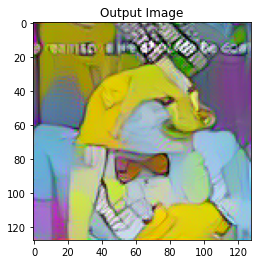

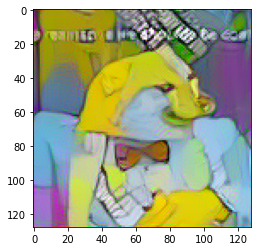

In [32]:
bot.polling()

\> stylm tramsmer